In [52]:
import pandas as pd
from textblob import TextBlob
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Load headline data
news_df = pd.read_csv("../yfinance_data/raw_analyst_ratings.csv")
stock_df = pd.read_csv("../yfinance_data/merged.csv")
print(news_df.columns)

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


In [54]:
print(stock_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Company'],
      dtype='object')


In [55]:
#display the first few rows of the dataframes
print(news_df.head())
print(stock_df.head())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [56]:
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')  # convert to datetime
news_df['date'] = news_df['date'].dt.date  # extract date only

In [57]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
stock_df['Date'] = stock_df['Date'].dt.date

In [58]:
# Step 3: Perform sentiment analysis on headlines
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Step 4: Aggregate sentiment by date and stock
daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

In [59]:
# Step 5: Compute daily stock returns
stock_df.sort_values(by=['Company', 'Date'], inplace=True)
stock_df['Daily_Return'] = stock_df.groupby('Company')['Adj Close'].pct_change()

# Step 6: Merge sentiment and stock data on date and stock/company

In [60]:
merged_df = pd.merge(
    daily_sentiment,
    stock_df,
    left_on=['date', 'stock'],
    right_on=['Date', 'Company'],
    how='inner'
).dropna(subset=['Daily_Return'])

# Step 7: Correlation Analysis
correlation, p_value = pearsonr(merged_df['sentiment'], merged_df['Daily_Return'])

# Output results
print("📊 Pearson Correlation Analysis:")
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Optional: Save merged data for dashboard or reporting
merged_df.to_csv("merged_sentiment_returns.csv", index=False)

📊 Pearson Correlation Analysis:
Correlation Coefficient: -0.0033
P-value: 0.9911


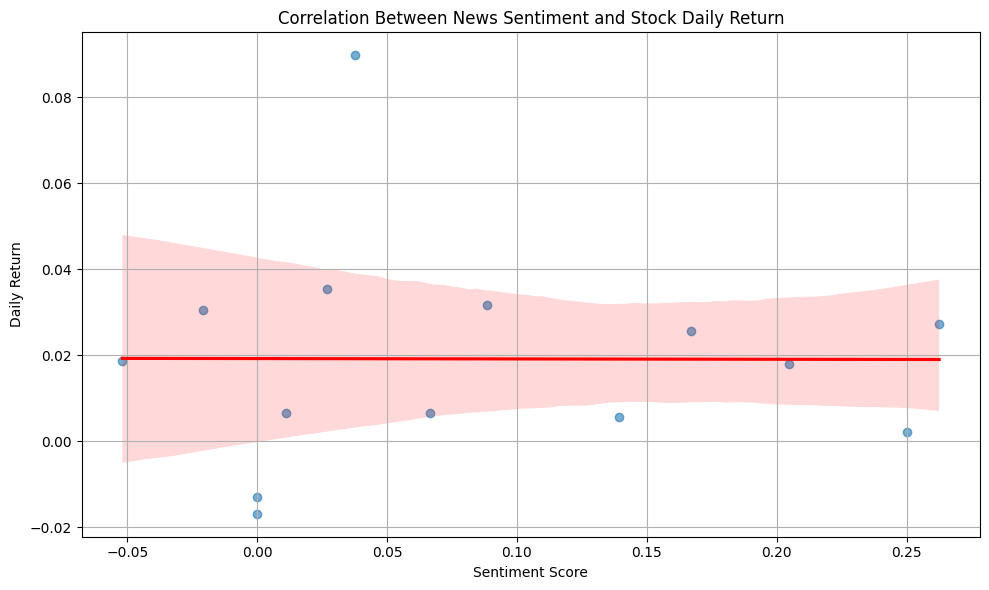

In [61]:
# Step 8: Plotting
plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged_df,
    x='sentiment',
    y='Daily_Return',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Correlation Between News Sentiment and Stock Daily Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Return')
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_vs_return_plot.png")  # Optional: save to file
plt.show()

In [62]:
#sentiment classification
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply to your data
news_df['sentiment_score'] = news_df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
news_df['sentiment_label'] = news_df['sentiment_score'].apply(classify_sentiment)

In [63]:
sentiment_counts = news_df['sentiment_label'].value_counts()
print(sentiment_counts)

sentiment_label
neutral     1046201
positive     270218
negative      90909
Name: count, dtype: int64


<Axes: xlabel='sentiment', ylabel='Daily_Return'>

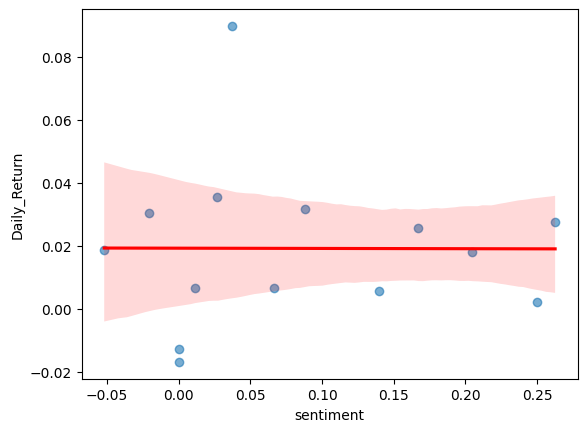

In [64]:
sns.regplot(
    data=merged_df,
    x='sentiment',
    y='Daily_Return',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)


C:\Users\ayish\AppData\Local\Temp\ipykernel_15204\3885389871.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=news_df, palette='coolwarm')


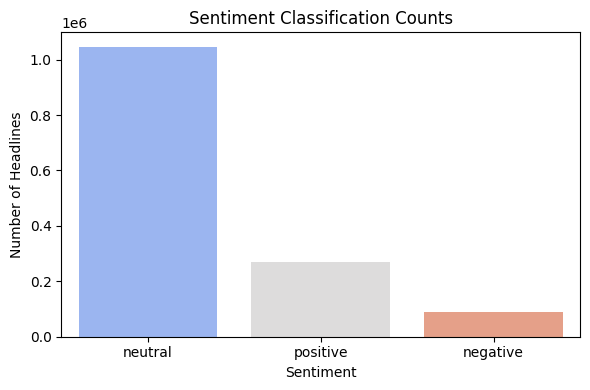

In [65]:
#Sentiment Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_label', data=news_df, palette='coolwarm')
plt.title("Sentiment Classification Counts")
plt.xlabel("Sentiment")
plt.ylabel("Number of Headlines")
plt.tight_layout()
plt.show()
